In [1]:
!pip install numpy
!pip install pandas
!pip install torch --user
!pip install scikit-learn --user
!pip install matplotlib --user

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import time


In [3]:
# Load the dataset
file_path = 'household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', na_values='?', low_memory=False)

# Combine and convert the Date and Time into a single Datetime column and set as index
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)
data.set_index('Datetime', inplace=True)

# Impute missing values based on the mean of the same time slot across different years
time_mean = data.groupby(data.index.time).mean()
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    fill_values = data.index.map(lambda x: time_mean.at[x.time(), col])
    data[col] = data[col].fillna(pd.Series(fill_values, index=data.index))

# Calculate the new feature 'Active_Energy_Not_Measured'
data['Active_Energy_Not_Measured'] = (data['Global_active_power'] * 1000 / 60) - (data['Sub_metering_1'] + data['Sub_metering_2'] + data['Sub_metering_3'])

## Resample the dataset to every 15 minutes
data_resampled = data.resample('15min').mean()

# Display the first few rows of the resampled dataframe to verify
data_resampled.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_Energy_Not_Measured
Datetime,,,,,,,,
2006-12-16 17:15:00,4.587333,0.484000,234.366667,19.700000,0.0,1.333333,16.833333,58.288889
2006-12-16 17:30:00,4.140667,0.327733,234.768667,17.773333,0.0,0.733333,16.866667,51.411111
2006-12-16 17:45:00,4.159333,0.028267,234.630000,17.786667,0.0,0.000000,16.866667,52.455556
2006-12-16 18:00:00,4.121067,0.152533,235.566000,17.706667,0.0,19.933333,17.000000,31.751111
2006-12-16 18:15:00,3.768533,0.017200,234.803333,16.226667,0.0,2.866667,16.933333,43.008889


<Axes: xlabel='Datetime'>

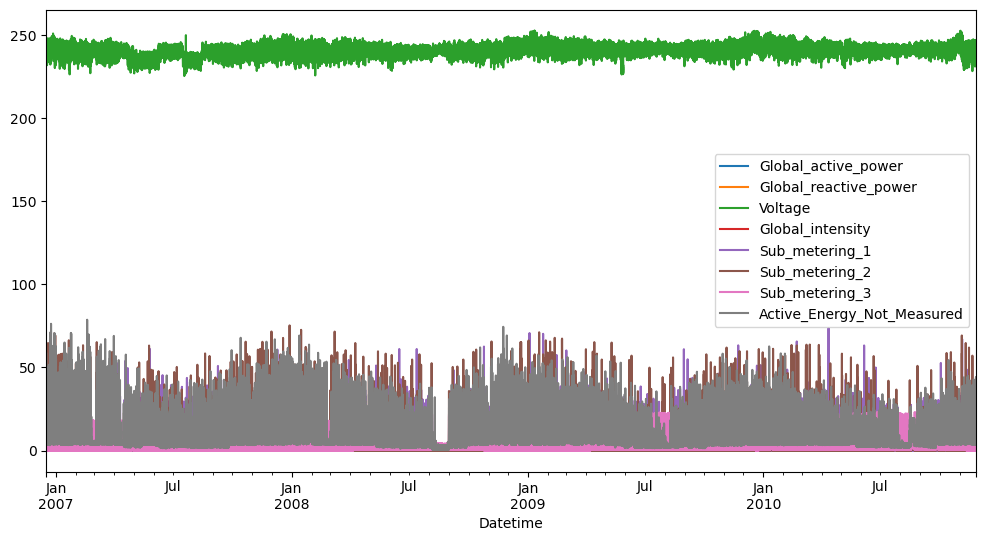

In [4]:

data_resampled.plot(figsize=(12,6))

In [5]:
data_resampled.shape

(138352, 8)

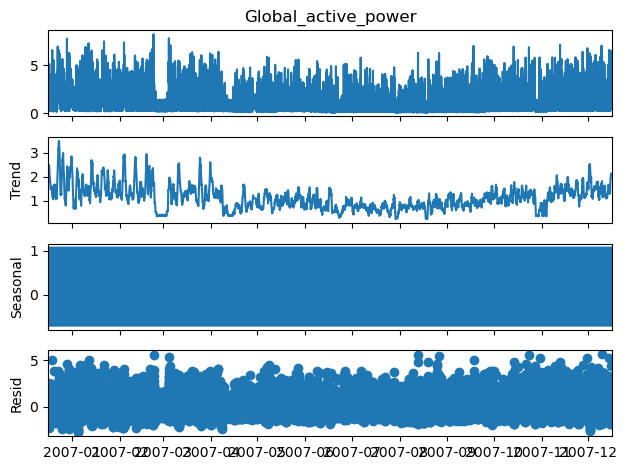

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompfreq = 6*12
results = seasonal_decompose(data_resampled["Global_active_power"][0:35000],period = 4*24)
results.plot();

In [7]:
global_dataset = data_resampled.iloc[:, :2]

In [8]:
global_dataset.shape

(138352, 2)

In [9]:

train = global_dataset.iloc[:110682]
test = global_dataset.iloc[110682:]

In [10]:
dataset_train = train.Global_active_power.values
dataset_train = np.reshape(dataset_train, (-1,1)) 
dataset_train.shape

(110682, 1)

In [11]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])

[[0.53125147]
 [0.47862899]
 [0.48082814]
 [0.47631988]
 [0.43478739]]


In [12]:

# Selecting Open Price values
dataset_test = test.Global_active_power.values 
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))  
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)  
print(*scaled_test[:5])

[0.03670864] [0.0283141] [0.02562085] [0.05556139] [0.06566981]


In [13]:

X_train = []
y_train = []
for i in range(96, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])
    if i <= 97:
        print(X_train)
        print(y_train)
        print()


[array([0.31721148, 0.32577245, 0.19211134, 0.19057194, 0.19573993,
       0.18256075, 0.23636135, 0.11880115, 0.03969463, 0.03914485,
       0.26430625, 0.19368216, 0.22954399, 0.19650964, 0.20651576,
       0.22597823, 0.2251614 , 0.51645434, 0.21226497, 0.22990528,
       0.20585602, 0.30689119, 0.26213851, 0.5946812 , 0.50963698,
       0.2791505 , 0.32770456, 0.30560312, 0.21523382, 0.20723834,
       0.23832488, 0.22725059, 0.19327375, 0.18248221, 0.16163742,
       0.18807433, 0.2136787 , 0.2178885 , 0.25001178, 0.24229905,
       0.23918883, 0.23226151, 0.3182011 , 0.44876769, 0.37087071,
       0.32137415, 0.44809224, 0.40307252, 0.35808423, 0.40605708])]
[0.39814014859961355]

[array([0.31721148, 0.32577245, 0.19211134, 0.19057194, 0.19573993,
       0.18256075, 0.23636135, 0.11880115, 0.03969463, 0.03914485,
       0.26430625, 0.19368216, 0.22954399, 0.19650964, 0.20651576,
       0.22597823, 0.2251614 , 0.51645434, 0.21226497, 0.22990528,
       0.20585602, 0.30689119, 0.26

In [14]:

X_test = []
y_test = []
for i in range(96, len(scaled_test)):
    X_test.append(scaled_test[i-96:i, 0])
    y_test.append(scaled_test[i, 0])

In [15]:

# The data is converted to Numpy array
X_train, y_train = np.array(X_train), np.array(y_train)
 
#Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)


# The data is converted to numpy array
X_test, y_test = np.array(X_test), np.array(y_test)
 
#Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_train : (110586, 50, 1) y_train : (110586, 1)
X_test : (27574, 96, 1) y_test : (27574, 1)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.saving import load_model

In [26]:
#Initialising the model
import os
import keras

regressorLSTM = Sequential()

create_model = False

if (os.path.exists('oneFeatureLSTM.keras') and not (create_model)):
    model = load_model('oneFeatureLSTM.keras')
    print("Model loaded successfully.")
    regressorLSTM = model
else:
    #Adding LSTM layers
    regressorLSTM.add(LSTM(96, 
                        return_sequences = True, 
                        input_shape = (X_train.shape[1],1)))
    regressorLSTM.add(LSTM(96, 
                        return_sequences = False))
    regressorLSTM.add(Dense(48))

    #Adding the output layer
    regressorLSTM.add(Dense(1))

    #Compiling the model
    regressorLSTM.compile(optimizer = 'adam',
                        loss = 'mean_squared_error',
                        metrics = ["accuracy"])

    #Fitting the model
    regressorLSTM.fit(X_train, 
                    y_train, 
                    batch_size = 1, 
                    epochs = 10)
   


    regressorLSTM.save('oneFeatureLSTM.keras')
regressorLSTM.summary()

Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,349 (1.33 MB)

 Trainable params: 116,449 (454.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,900 (909.77 KB)

In [24]:
y_LSTM = regressorLSTM.predict(X_test)
y_LSTM_O = scaler.inverse_transform(y_LSTM) 

862/862 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step


In [25]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_targets = test.Global_active_power
rmse = np.sqrt(mean_squared_error(test_targets.to_numpy()[96:], y_LSTM_O))
mae = mean_absolute_error(test_targets.to_numpy()[96:], y_LSTM_O)
r2 = r2_score(test_targets.to_numpy()[96:], y_LSTM_O)
print(f'Test RMSE: {rmse}, Test MAE: {mae}, Test R squared score: {r2}')

Test RMSE: 0.4532959906502231, Test MAE: 0.2744275204037485, Test R squared score: 0.6921564763059247


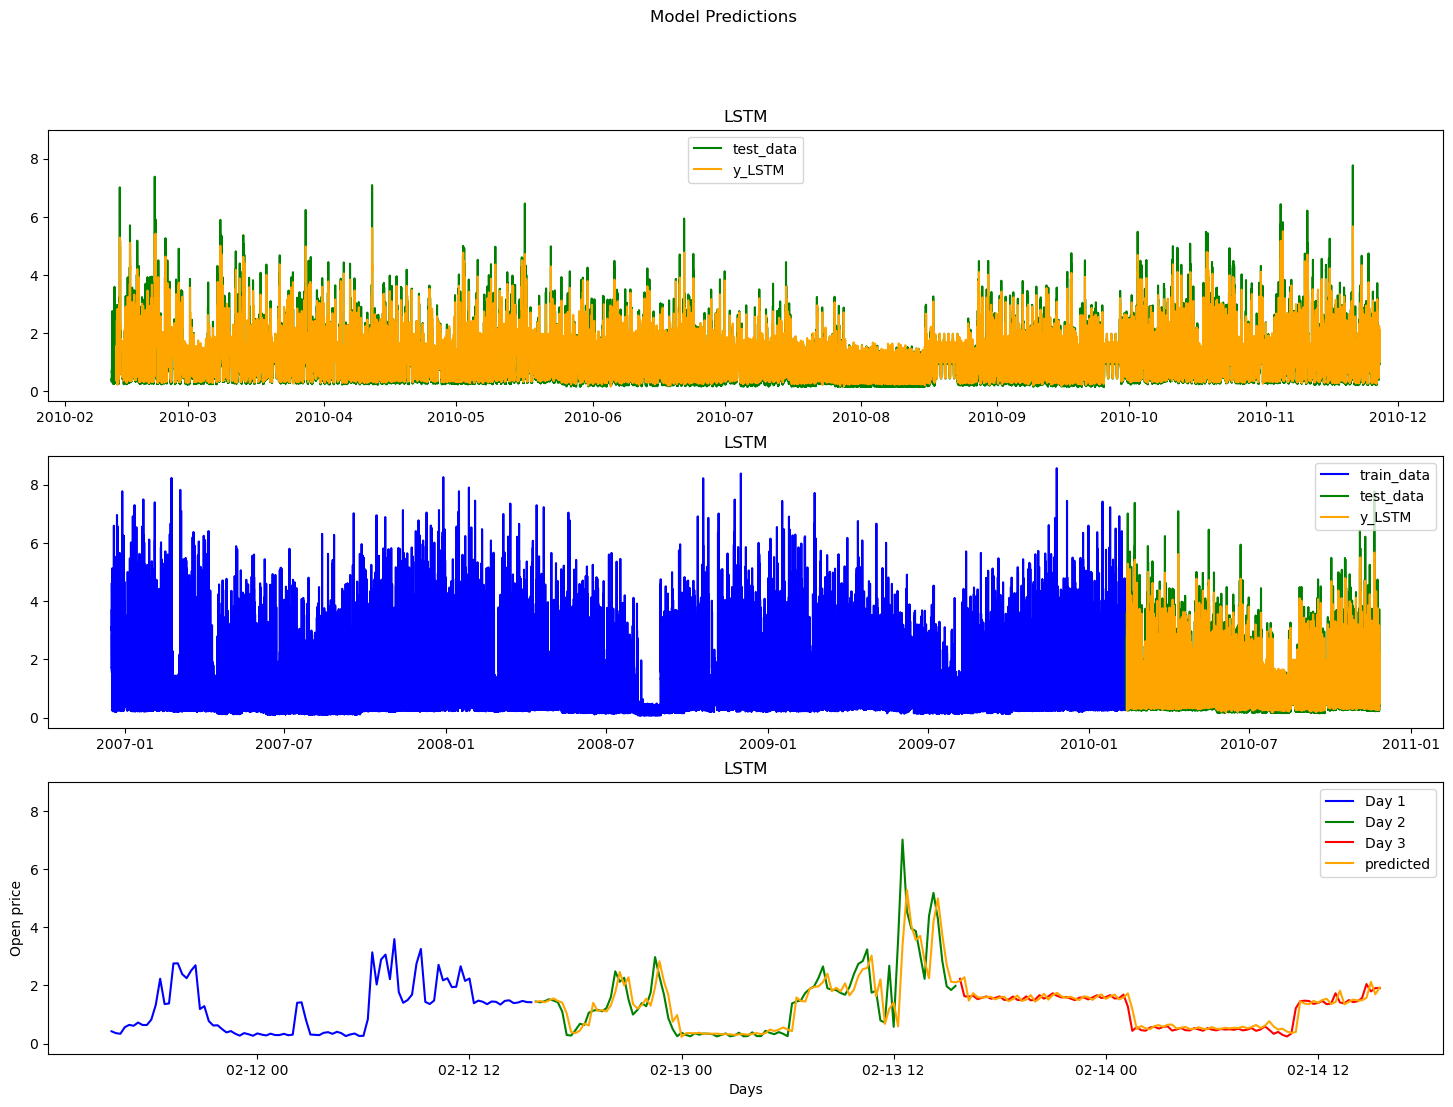

In [37]:

fig, axs = plt.subplots(3,figsize =(18,12),sharex=False, sharey=True)
fig.suptitle('Model Predictions')

#Plot for LSTM predictions
axs[1].plot(train.index, train.Global_active_power, label = "train_data", color = "b")
axs[1].plot(test.index, test.Global_active_power, label = "test_data", color = "g")
axs[1].plot(test.index[96:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")
axs[0].plot(test.index, test.Global_active_power, label = "test_data", color = "g")
axs[0].plot(test.index[96:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[0].legend()
axs[0].title.set_text("LSTM")

axs[2].plot(test.index[:96], test.Global_active_power[:96], label = "Day 1", color = "blue")
axs[2].plot(test.index[96:192], test.Global_active_power[96:192], label = "Day 2", color = "g")
axs[2].plot(test.index[192:288], test.Global_active_power[192:288], label = "Day 3", color = "red")

axs[2].plot(test.index[96:288], y_LSTM_O[:192], label = "predicted", color = "orange")
axs[2].legend()
axs[2].title.set_text("LSTM")
    
plt.xlabel("Days")
plt.ylabel("Open price")
 
plt.show()

In [35]:
print(y_LSTM_O)

[[1.4316877]
 [1.4625349]
 [1.4211586]
 ...
 [1.0015291]
 [1.1126072]
 [1.0581882]]
